# PyTorchで LSTM 体験
### LSTMの対象：時系列データ（文章、音声、気温、株価、動き(3軸加速度)など）
### この演習では X軸方向の加速度データ（sin波で単純化した疑似データ）の値をLSTMに予測させる。=次の動きを予測させるようなイメージ
### CPU（ノートPCで十分に計算可能）

```
以下の問に対して、すべての解答をこの.ipynbファイルに入力し、所定のGoogleClassroomに提出しなさい。


【必須】
問1 LSTMについて、用語（RNN、再帰、長期記憶、短期記憶）を用いて簡単に説明しなさい。
問2 シーケンスとは何か、sequentialの意味から説明しなさい。
問3 下記のコードとコメントを参照しながら、予測結果表示までの作業手順（実装方法）を番号付き箇条書きで示しなさい。
問4 シーケンス長を変更し、予測値の精度を上げなさい（2つの曲線がぴったり重なるように）。実際に下記のコードに対してシーケンス長を変更して実行し、予測結果（グラフ）を示すとともに、シーケンス長と精度の関係性について簡単に述べなさい。

【任意】
問5 入力データを下記の例とは異なる波で設定し、実行した結果を示しなさい。
問6 実際の株価や気温などの時系列データを用いて予測結果を示しなさい（ネットや書籍のコードを模倣しても構わない）。
```

【必須】問1　解答欄

RNNとは、再帰型ニューラルネットワークであり、ニューラルネットワークを拡張して時系列データを扱えるようにしたものである。LSTMとは、過去の中間層出力の反映が困難であるというRNNの欠点を改善したネットワークである。LSTMは、神経科学をベースにデザインされたものである。長期記憶は、長期間にわたって記憶されているものである。一方、短期記憶は、一時的な想起は可能であるが、長い期間がたつと忘れてしまう記憶である。LSTMは、RNNの中間層出力に対して、記憶期間の長さの考え方を導入することにより、過去の出力の影響を保持することを可能にしている。

【必須】問2　解答欄

sequentialとは、連続的という意味である。したがってシーケンスとは、系列データ(同質のデータを直列に並べたデータ)である。

【必須】問3　解答欄

予測結果表示までの実装手順
1. ライブラリのインポート
1. 入力データの用意
1. シーケンス長を設定、入力データをシーケンスに変換(学習データと教師データそれぞれに対して行う)
1. 訓練データと検証データの作成(学習データと教師データそれぞれに対して行う)
1. LSTMへの入力形式（シーケンス長、バッチサイズ、入力次元）に合わせてデータを前処理
1. ネットワークモデルの定義
1. ネットワークモデルの実装
1. 損失関数と最適化関数の設定
1. ネットワークモデルの学習
1. 予測結果表示、グラフ化

【必須】問4　解答欄

下記のコードはシーケンス長を10から55に変更して実行し、予測値の精度を上げたグラフを示している。  
シーケンス長を増やすことで、誤差の振れ幅を抑えることができる。シーケンス長を増やすことで基本的には精度を上げることができるが、増やしすぎると精度は低下する。

## ライブラリのインポート

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn') # すべてのグラフに縦線を入れたかったので
%matplotlib inline

## 入力データの用意

```今回は例として、X軸方向の加速度データ【sin波で単純化した疑似データ】を自作 ```

In [160]:
# 入力データとしてsin波を設定
t = np.linspace(0, 499, 500) # 時刻t：0〜499まで1刻みで設定
x_acc = np.sin(t * np.pi / 50)

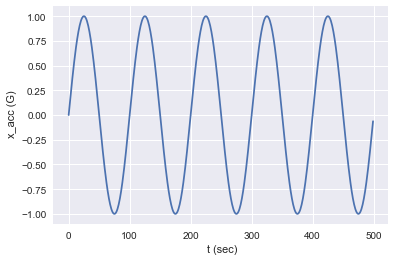

In [161]:
plt.grid(linewidth=1)
plt.ylabel(' x_acc (G)') # X軸方向の加速度と想定
plt.xlabel(' t (sec)') # 時間軸と想定
plt.plot(t, x_acc);

## シーケンスの作成　（学習データと教師データのそれぞれに対して）
``` LSTMのモデルを利用するためには入力データを一定長のデータ＝シーケンスに変換する必要がある ```

``` 下記の例では シーケンス長を10に設定（10秒間隔で切り出したデータと想定）```

In [162]:
# 入力データ：x_acc = np.sin(x * np.pi / 50)

#######################################

seq_length = 55 # シーケンス長を 10 に設定 
                # 検証データ数を10とするとき シーケンス長のMaxは489
#######################################

input_length = len(x_acc)

input_seq_data = [] # 学習データのシーケンス格納用配列
teaching_seq_data = [] # 教師データのシーケンス格納用配列

for i in range(input_length - seq_length): # 500の全データから10のシーケンス長を引いた「490」回繰り返す
    input_seq_data.append( x_acc[ i : i+seq_length])
    # 入力データ「x_acc」に対して、シーケンス分「10個」のデータを切り出し、配列に追加していく
    # i=0  1回目：x_acc[0]からx_acc[9]までの値をinput_seq_data配列に追加
    # i=1  2回目：x_acc[1]からx_acc[10]までの　　　　 〃  
    # ・・・
    # i=489 490回目：x_acc[489]からx_acc[499]までの　〃  
    
    teaching_seq_data.append( x_acc[ i+seq_length : i+seq_length+1]) 
    # 教師データには学習データのシーケンス分だけ先「10個先」のデータを格納
    # i=0：  x_acc[10]の値をinput_seq_data配列に追加
    # i=1：  x_acc[11]の   　     〃  
    # ・・・
    # i=489：x_acc[499]の　      〃

# numpy 配列に変換
np_arr_input = np.array(input_seq_data)
np_arr_teach = np.array(teaching_seq_data)

print('学習データ：', np_arr_input.shape)
# シーケンス長=10なので10刻みでデータが格納されている
# 490行 x 10列 のデータ（1行あたり10個のデータが格納されている）

print('教師データ：', np_arr_teach.shape)
# 490行 x 1列 のデータ（１行あたり１個のデータが格納されている）

学習データ： (445, 55)
教師データ： (445, 1)


## 訓練データと検証データの作成　（学習データと教師データのそれぞれに対して）

In [163]:
#検証データ数を設定
num_test = 10

# 学習データについて
# 訓練データを作成（全490行のうち、先頭から480行を訓練データとする）
input_seq_train = np_arr_input[:-num_test] # 下の処理を簡略化した書き方
#input_seq_train = np_arr_input[0:len(np_arr_input)-num_test]

# 検証データを作成（全490行のうち、下から10行を検証データとする）
input_seq_test = np_arr_input[-num_test:]



# 教師データについて
# 訓練データを作成（全490行のうち、先頭から480行を訓練データとする）
teach_seq_train = np_arr_teach[:-num_test] # 下の処理を簡略化した書き方
#teach_seq_train = np_arr_teach[0:len(np_arr_teach)-num_test]

# 検証データを作成（全490行のうち、下から10行を検証データとする）
teach_seq_test = np_arr_teach[-num_test:]

print(input_seq_train.shape) # 480行 x 10列 のデータ
print(input_seq_test.shape)  #  10列 x 10列 のデータ
print(teach_seq_train.shape) # 480行 x  1列 のデータ
print(teach_seq_test.shape)  #  10列 x  1列 のデータ
# 全部で490個あったデータから最初の480を訓練データ、残りの10個を検証データに分けたことを確認できる

(435, 55)
(10, 55)
(435, 1)
(10, 1)


## LSTMのモデルに入力するためにデータを前処理する
``` LSTMへの入力形式（シーケンス長、バッチサイズ、入力次元）```

``` 今回はバッチサイズ＝訓練データ数（つまり480）```

``` 入力次元は x_acc だけなので 1次元 ```

In [164]:
# 32bitの浮動小数点数型tensorに変換する
train_t = torch.FloatTensor(input_seq_train)
teach_t = torch.FloatTensor(teach_seq_train)

print(train_t.size())
print(teach_t.size())
# Tensor型に変換されていることを確認、データ数、シーケンス長の順番で格納されている

torch.Size([435, 55])
torch.Size([435, 1])


In [165]:
# 列の順番を入れ替える　シーケンス長を1番目最初に移動する
seq_train_t = train_t.permute(1, 0)
seq_teach_t = teach_t.permute(1, 0)

print(seq_train_t.size())
print(seq_teach_t.size())

torch.Size([55, 435])
torch.Size([1, 435])


In [166]:
# ３つ目の軸、入力次元数を設定するために unsquesszeを用いて　一番最後に1を付与する
train_data = seq_train_t.unsqueeze(dim= -1)
teach_data = seq_teach_t.unsqueeze(dim= -1)

print(train_data.size())
print(teach_data.size())

torch.Size([55, 435, 1])
torch.Size([1, 435, 1])


## ネットワークモデルの定義

In [167]:
# LSTMは全結合(Linear)層とセットで使用する

class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        # input_size：入力次元 シーケンス長：10、1次元データ        
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x) # 2つの値が返ってくる：出力値(シーケンス)、隠れ層やセルの状態がタプル型でまとまったもの
                            # xに格納される1つ目の出力値だけを用いる。２つ目の返り値は不要なので変数を用意しない（メモリ節約）
        # print(len(x))
        x_last = x[-1] # 出力値(シーケンス)の一番最後の値だけを取り出す
        x = self.linear(x_last) 
        return x

## ネットモデルの実装

In [168]:
# モデルの実装　隠れ層のサイズを100として実装
model = LSTM(100)

## 損失関数と最適化関数を定義する（設定する）

In [169]:
criterion = nn.MSELoss() # 損失関数として回帰問題用のMSEを用いる
optimizer = optim.Adam(model.parameters(), lr=0.001) # 最適化関数のAdamを用いる

## ネットワークモデルの学習

In [170]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    # 今回はミニバッチ学習ではなく、バッチ学習なので最適化関数の初期化から始める
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, teach_data)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    print("epoch: {}, loss: {}".format(epoch, loss.item()))

/Users/minamikota/AI_design_1/.venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 435, 1])) that is different to the input size (torch.Size([435, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.5212289094924927
epoch: 1, loss: 0.5074931383132935
epoch: 2, loss: 0.49416422843933105
epoch: 3, loss: 0.4811447262763977
epoch: 4, loss: 0.46831566095352173
epoch: 5, loss: 0.45555830001831055
epoch: 6, loss: 0.4427546262741089
epoch: 7, loss: 0.4297730326652527
epoch: 8, loss: 0.41645848751068115
epoch: 9, loss: 0.40263187885284424
epoch: 10, loss: 0.3880908489227295
epoch: 11, loss: 0.3726087212562561
epoch: 12, loss: 0.35592901706695557
epoch: 13, loss: 0.3377537131309509
epoch: 14, loss: 0.31773829460144043
epoch: 15, loss: 0.29551225900650024
epoch: 16, loss: 0.2707715332508087
epoch: 17, loss: 0.24357961118221283
epoch: 18, loss: 0.21531327068805695
epoch: 19, loss: 0.19142474234104156
epoch: 20, loss: 0.18119266629219055
epoch: 21, loss: 0.16440799832344055
epoch: 22, loss: 0.13796520233154297
epoch: 23, loss: 0.11883452534675598
epoch: 24, loss: 0.11096299439668655
epoch: 25, loss: 0.10972022265195847
epoch: 26, loss: 0.1097341775894165
epoch: 27, loss: 0.10

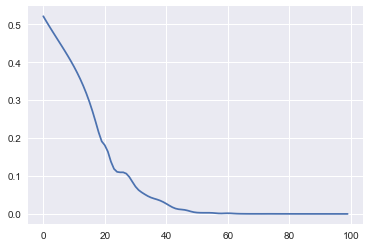

In [171]:
plt.plot(losses)

In [172]:
# 訓練データのときと同様に Tensor変換、列の入れ替え、次元の追加をおこなう
test_data = torch.FloatTensor(input_seq_test)
test_data = test_data.permute(1, 0)
test_data = test_data.unsqueeze(dim=-1)
test_data.size()

torch.Size([55, 10, 1])

In [173]:
x_acc_pred = model(test_data)
x_acc_pred.size()

torch.Size([10, 1])

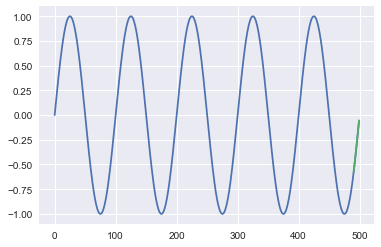

In [174]:
# まずは全体を表示　x = 490 〜 500 の一致度を確認　緑色が予測線
plt.plot(t, x_acc)
plt.plot(np.arange(490, 500), x_acc_pred.detach())

(450.0, 500.0)

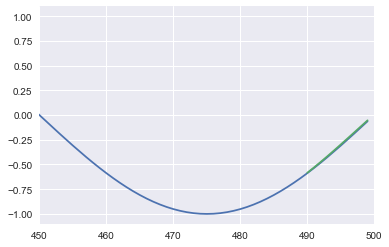

In [175]:
# 一致度を分かりやすくするために450-500付近を拡大表示

plt.plot(t, x_acc)
plt.plot(np.arange(490, 500), x_acc_pred.detach())
plt.xlim([450, 500])